In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# $g_z(x) = G \frac{\left(\frac{4}{3}\pi R^3 Z_0 \rho\right)}{((x - x_0)^2 + z_0^2)^{3/2}}$


#### $G = 6.67x10^{-11} (m^3 kg^{-1} s^{-2})$

In [2]:
# G konstanta
G_konstanta = 6.67e-11 # SI

# parameter model sintetik
x0 = 400 # m
z0 = 300 # m
R = 100 # m
rho = 3000 # kg/m3

# variabel bebas x
x = np.arange(0, 1001, 50)

In [3]:
# fungsi forward modelling bola homogen
def f(x0, z0, R, rho):
    return G_konstanta*((4/3)*np.pi*(R**3)*z0*rho)/(((x-x0)**2 + (z0**2))**(3/2))*10e5

# fungsi bola
def bola(x0, z0, R):
    q = np.linspace(0, 2*np.pi, 1000)
    
    xBola = R*np.cos(q)+x0
    zBola = R*np.sin(q)+z0
    
    return xBola, zBola

In [4]:
# membuat data sintetik
gz_obs = f(x0, z0, R, rho) # data observasi anomali gravitasi
xb1, yb1 = bola(x0, z0, R) # untuk plot bola

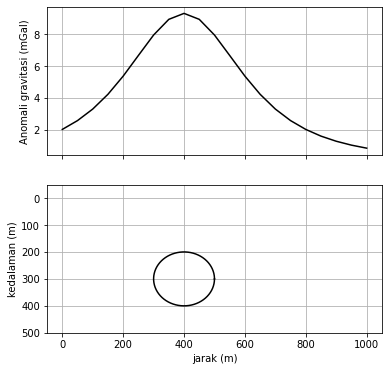

In [5]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

ax1.plot(x, gz_obs, 'k')
ax1.set_ylabel("Anomali gravitasi (mGal)")
ax1.grid()

ax2.plot(xb1, yb1, 'k')
ax2.set_ylim(-50, 500)
ax2.grid()
ax2.set_ylabel("kedalaman (m)")
ax2.set_xlabel("jarak (m)")
ax2.invert_yaxis()

plt.show()

# Inversi Non-Linear x0 dan z0
## Ekspansi Taylor Orde Pertama

In [6]:
# data sintetik:
gz_obs

array([2.01162461, 2.56695675, 3.29266991, 4.22233014, 5.36465656,
       6.66389536, 7.95164445, 8.93808239, 9.31307689, 8.93808239,
       7.95164445, 6.66389536, 5.36465656, 4.22233014, 3.29266991,
       2.56695675, 2.01162461, 1.58952787, 1.26834843, 1.02258039,
       0.83298692])

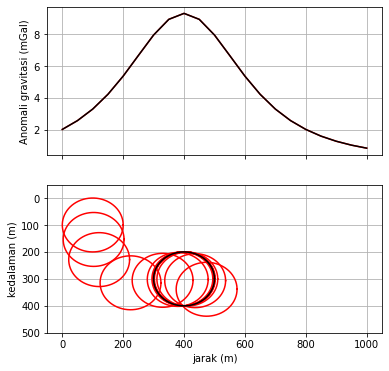

In [43]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

# model awal
model_awal = [100, 100] # [x0,z0]

banyak_iterasi = 100
misfit = np.array([np.inf])

# inversi non-linear
for i in range(banyak_iterasi):
    xb, yb = bola(model_awal[0], model_awal[1], R)
    ax2.plot(xb, yb, 'red')
    
    # forward modelling
    gz_calc = f(model_awal[0], model_awal[1], R, rho)
    delta_gz = (gz_obs - gz_calc)
    
    # menghitung misfit / eror
    rms = np.sqrt(np.mean(delta_gz**2))
    # menyimpan rms ke misfit
    misfit = np.append(misfit, rms)
    
    if np.isclose(misfit[i], misfit[i-1]) or misfit[i] == 0:
        break
    else:
        # matrix jacobi
        dgz_dx0 = G_konstanta*(4/3)*np.pi*(R**3)*model_awal[1]*rho*2*(x-model_awal[0])/(((x-model_awal[0])**2 + (0-model_awal[1])**2)**(5/2))*10e5
        dgz_dz0 = G_konstanta*(4/3)*np.pi*(R**3)*model_awal[1]*rho*2*(0-model_awal[1])/(((x-model_awal[0])**2 + (0-model_awal[1])**2)**(5/2))*10e5
        J = np.column_stack([dgz_dx0, dgz_dz0])
        
        # inversi
        model_kalkulasi = np.linalg.inv((J.T).dot(J)).dot(J.T).dot(delta_gz)
        
        # update model
        model_awal = model_awal + model_kalkulasi
        

ax1.plot(x, gz_calc, 'red')
ax1.plot(x, gz_obs, 'k')
ax1.set_ylabel("Anomali gravitasi (mGal)")
ax1.grid()

ax2.plot(xb1, yb1, 'k', markersize=22)
ax2.set_ylim(-50, 500)
ax2.grid()
ax2.set_ylabel("kedalaman (m)")
ax2.set_xlabel("jarak (m)")
ax2.invert_yaxis()
fig.savefig('1.png',dpi=300, transparent=False)
plt.show()

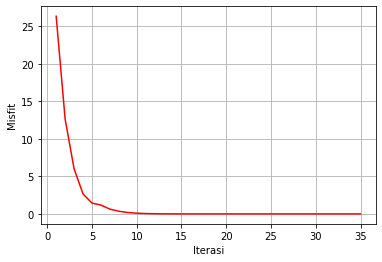

In [45]:
x_misfit = np.arange(len(misfit))

plt.plot(x_misfit, misfit, 'red')
plt.xlabel("Iterasi")
plt.ylabel("Misfit")
plt.grid()
plt.savefig('2.png',dpi=300, transparent=False)
plt.show()